## Ideas and Solution
- Major problems are that: 
- **1. how to process the missing data? **
> I try two ways, one is processing the features, make some similar features with no missing to replace; another is to delete or fill the missing samples.    
> I think the first way is better. Because for financial indicators, it is not reasonable to use average or midean to replace the missing value. So I generate many features to replace features with many missing.
- **2. how to choose useful features?**
> I use logical analysis: I believe we majorly need three factors: asset and leverage, operating situation, sales and profit. And the financial indicator which is divededy by total asset is better, because if it is divededy by sales, but sales can be very small or even negative. So I make and choose features in show these information and are devided by totally asset.   
> I also use Random Forest to see the importance of features and delete some.   
- **3. how to deal with imbalanced data?**
> I use AUC to show judge the model.  
> I set different weights to 0 and 1.


## Preparation
1. import packages
2. define functions
> 1 run different models and return the accuracy (in sample and out of sample)  
> 2 use Random Forest to calculate the importance of each features, and return photo  
> 3 split data, run models and return accuracy and importance

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# run different models
def Run_Model(model_name, x_train, y_train, x_test, y_test, w0, w1, threshold):  
# model_name is a string, w0 w1 are the weight of 0 and 1 in Bankrupt to deal with umblanced model, threshold is 0 mean no threshold
    if model_name == 'NB':  # judge which model should be used
        model = GaussianNB()  
        y_score = 0  # NB can not calculate y_score
    elif model_name == 'LR':
        model = LogisticRegression(penalty='l2',C=1,class_weight={1:w1,0:w0}) 
        y_score = 1  # LR could calculate y_score
        
    model.fit(x_train, y_train)  
    if threshold == 0:
        y_pred1 = model.predict(x_train)  # in sample prediction
        y_pred2 = model.predict(x_test)  # out of sample prediction
    # when set a threshold
    else:
        y_pred_prob1 = model.predict_proba(x_train)[:,1]  # in sample prediction
        y_pred_prob2 = model.predict_proba(x_test)[:,1]
        y_pred1 = y_pred_prob1 > threshold
        y_pred2 = y_pred_prob2 > threshold

    accuracy1 = accuracy_score(y_train, y_pred1)  # in sample accuracy
    accuracy2 = accuracy_score(y_test, y_pred2)  # out of sample accuracy
    # AUC
    if y_score == 1:
        y_score = model.fit(x_train, y_train).decision_function(x_test)
    
    scores = cross_val_score(model, x_train, y_train, cv=5)  # cross volidation
    cross_val_avg = scores.mean()
    #confusion_matrix
    c=confusion_matrix(y_test, y_pred2)

    return accuracy1, accuracy2, scores, y_pred1, y_pred2, y_score, c


# print the importance of features
def Pick_Feature(data): 
    # drop nan, in case
    data = data.replace('?',np.nan)
    data = data.dropna()
    data = pd.DataFrame(data,dtype=np.float)
    # split data
    data = shuffle(data, random_state = 30).copy()
    x, y = data.iloc[:,:].copy(), data['Bankrupt']
    del x['Bankrupt'], x['Id']
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=30)
    # train random forest
    feat_labels = x_train.columns[:]
    forest = RandomForestClassifier(n_estimators=1000,n_jobs=-1,random_state=0,class_weight={1:1,0:0.5})
    forest.fit(x_train,y_train)
    # print importance
    importances = forest.feature_importances_
    indices=np.argsort(importances)[::-1]
    # print photo
    f, ax = plt.subplots(figsize=(13, 6))
    plt.title('Feature Importance-RandomForest')
    plt.bar(range(x_train.shape[1]),importances[indices],color='lightblue',align='center')
    plt.xticks(range(x_train.shape[1]),feat_labels,rotation=90)
    plt.xlim([-1,x_train.shape[1]])
    plt.tight_layout()
    plt.show()
    
    
# combine Run_Model and Pick_Feature
def Run_Pick(data, w0, w1, importance, matrix, threshold, AUC):
# w0 w1 is weight, AUC = 1 means print AUC photo
    data = data.dropna()
    data = shuffle(data, random_state = 30).copy()

    # split train data into training and testing
    x, y = data.iloc[:,:].copy(), data['Bankrupt']
    del x['Bankrupt'], x['Id']
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=10)
    print("train data has {a} sample, test data has {b} sample".format(a = len(x_train), b = len(x_test)))

    model = "Naive Byes"
    accuracy1, accuracy2, scores,y_pred1, y_pred2, y_score, c = Run_Model('NB', x_train, y_train, x_test, y_test, w0, w1, threshold)
    print("{m:s}: CV score = {sc:3.2f}, in sample Accuracy = {a1:.2%}, out of sample Accuracy = {a2:.2%}".format(\
                    m=model, sc=scores.mean(), a1=accuracy1, a2=accuracy2))

    model = "Logistic"
    accuracy1, accuracy2, scores,y_pred1, y_pred2, y_score, c = Run_Model('LR', x_train, y_train, x_test, y_test, w0, w1, threshold)
    model_fpr, model_tpr, _ = roc_curve(y_test,y_score)
    roc = roc_auc_score(y_test, y_score)
    print("{m:s}: CV score = {sc:3.2f}, in sample Accuracy = {a1:.2%}, out of sample Accuracy = {a2:.2%}, roc = {r:.2%}".format(\
                    m=model, sc=scores.mean(), a1=accuracy1, a2=accuracy2, r = roc))
    # whether print confusion_matrix
    if matrix == 1:
        print('\nconfusion_matrix\n',c)
    # whether print AUC
    if AUC == 1:
        plt.figure(figsize = (6, 5))
        plt.rcParams['font.size'] = 16
        # Plot both curves
        plt.plot(model_fpr, model_tpr, 'r', label = 'model')
        plt.legend()
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves of Logistic Regression')
        plt.show()
    # whether print features importance
    if importance == 1:
        Pick_Feature(data)

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Simply clean data and try basic models
- Simply look at the data and clean it
> 1. There are many duplication in data set, so delete the deplicate one.
> 2. Rename the columns name to make it easier to be understand.
> 3. There are many '?' and '0' in data, we just delete '?' and leave '0' here, and then convert them into float.
- Try Naive Byes and Logistic Regression model, to see the result.  
(basically, I am deleting data in rows here.)

Originally there are 3107 samples, 410 is bankrupt, 2697 is not
train data has 1075 sample, test data has 462 sample
Naive Byes: CV score = 0.18, in sample Accuracy = 17.21%, out of sample Accuracy = 17.97%
Logistic: CV score = 0.93, in sample Accuracy = 94.14%, out of sample Accuracy = 91.34%, roc = 64.26%


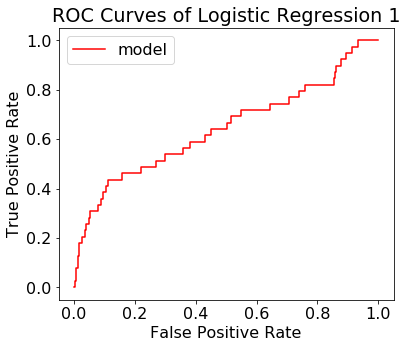

In [3]:
DATA_PATH = "./data/midterm_project"
df = pd.read_csv( os.path.join(DATA_PATH, "bankruptcy_data.csv") )
# delete duplications
df = df.drop_duplicates()
# rename columns
df.columns = ['Id','NP/TA','TL/TA','WC/TA','CA/SL','C+SS+R-SL/OE-D_y','RE/TA','EBIT/TA','BVE/TL','S/TA','E/TA',
    'GP+E+F/TA','GP/SL','GP+D/S','GP+I/TA','TL/GP+D_y','GP+D/TL','TA/TL','GP/TA','GP/S','I/S_y',
    'S_grows','PO/TA','NP/S','GP3/TA','E-S/TA','NP+D/TL','PO/FE','WC/FA','lgTA','TL-C/S',
    'GP+I/S','CL/CS_y','OE/SL','OE/TL','P/TA','TS/TA','CA-I/LL','CC/TA','P/S','CA-I-R/SL',
    'TL/PO+D_d_m','PO/S','RR+I_d','R/S_y','NP/I','CA-I/SL','I/CS_y','EBITDA/TA','EBIT/S','CA/TL',
    'SL/TA','SL/CP_y','E/FA','CC/FA','WC','S-CS/S','CA-I-SL/S-GP-D','TC/TA','LL/E','S/I',
    'S/R','SL/S_y','S/SL','S/FA','Bankrupt']

print('Originally there are {a} samples, {b} is bankrupt, {c} is not'.format(a = len(df), \
                                             b = len(df.loc[df['Bankrupt'] == 1]) , c = len(df.loc[df['Bankrupt'] == 0])))

data = df.replace('?',np.nan)
data = data.dropna()
data = pd.DataFrame(data,dtype=np.float)

# split train data into training and testing
x, y = data.iloc[:,:].copy(), data['Bankrupt']
del x['Bankrupt'], x['Id']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=10)
print("train data has {a} sample, test data has {b} sample".format(a = len(x_train), b = len(x_test)))

model = "Naive Byes"
accuracy1, accuracy2, scores,y_pred1, y_pred2, y_score, c = Run_Model('NB', x_train, y_train, x_test, y_test, w0=1, w1=1, threshold=0)
print("{m:s}: CV score = {sc:3.2f}, in sample Accuracy = {a1:.2%}, out of sample Accuracy = {a2:.2%}".format(\
                m=model, sc=scores.mean(), a1=accuracy1, a2=accuracy2))

model = "Logistic"
accuracy1, accuracy2, scores,y_pred1, y_pred2, y_score, c = Run_Model('LR', x_train, y_train, x_test, y_test, w0=1, w1=1, threshold=0)
model_fpr, model_tpr, _ = roc_curve(y_test,y_score)
roc = roc_auc_score(y_test, y_score)
print("{m:s}: CV score = {sc:3.2f}, in sample Accuracy = {a1:.2%}, out of sample Accuracy = {a2:.2%}, roc = {r:.2%}".format(\
                m=model, sc=scores.mean(), a1=accuracy1, a2=accuracy2, r = roc))

plt.figure(figsize = (6, 5))
plt.rcParams['font.size'] = 16
# Plot both curves
plt.plot(model_fpr, model_tpr, 'r', label = 'model')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves of Logistic Regression 1')
plt.show()

### Comment:
1. It is very strange to see that Naive Bayes presents badly, but Logistic Regression is extremely great. It might cause by I deleting a half of the sample, since there are too many missing value.
2. The AUC ROC result is not good. These samples are imbalanced, too many bankrupt here, so **ROC is actually more reasonable than accuracy.**
3. **Next Step: delete the columns, which have missing value, and try the same model.**  
(we are deleting in columns here.)

train data has 2174 sample, test data has 933 sample
Naive Byes: CV score = 0.71, in sample Accuracy = 85.88%, out of sample Accuracy = 88.00%
Logistic: CV score = 0.86, in sample Accuracy = 86.38%, out of sample Accuracy = 87.35%, roc = 68.22%


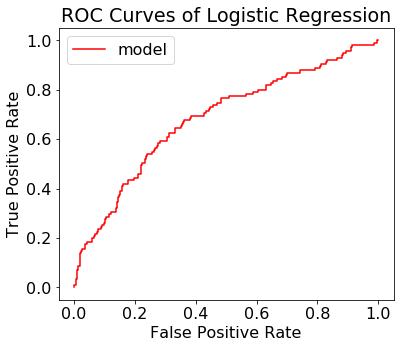

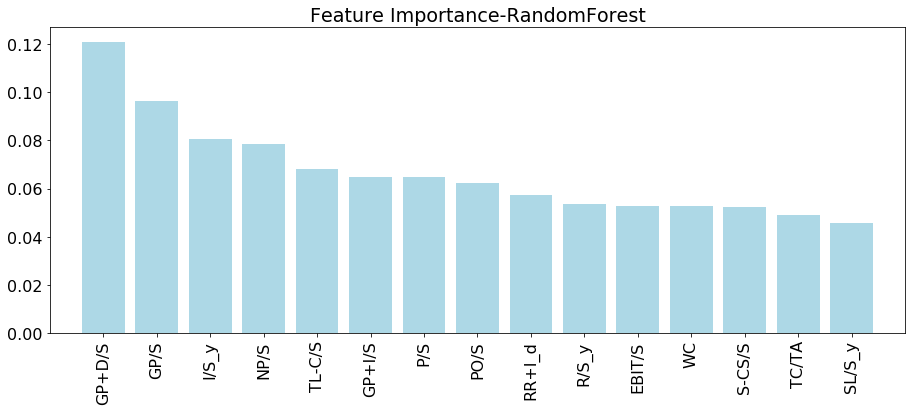

In [4]:
# count how many '?' in each colmun.
tem = pd.DataFrame((df == '?').sum().sort_values(ascending=False),columns=['not a ?'])
# pick up the columns with no '?'
data = df.loc[:,list(tem.loc[tem['not a ?'] == 0].index)]
data = data.dropna()
data = pd.DataFrame(data,dtype=np.float)
# run the same model as above, and print the importance of features (details are in function definition)

Run_Pick(data, w0=1, w1=1, importance = 1, matrix = 0, threshold=0, AUC = 1)

### Comment
1. The result is much better. Since the NB and LR models have the simlar result and the ROC improves a little. **Also deleting in columns is reasonable, bacause we will not have bais in choosing samples, and if we fill average or median into missing, it will also be strange. I choose this model as a base model.**
2. From the importance photo we can see all features are important, and it may be because there is few features.
3. **Next Step: Process the missing values, try to add more features in the model.**

## Missing Value & Feature Engineering
- For convenience, I didn't split the train set into two parts. I will do that after exporing the features.
- Here, I am counting how many '?' in each feature, and in these missings how many samples are bankrupt.

In [6]:
data = df.copy()
print('feature  amount  percent of Bankruptcy in missing \n')
question_mark_total = (data == '?').sum().sort_values(ascending=False)
question_mark_percent = ((data == '?').sum()/data.count()).sort_values(ascending=False)
question_mark_data = pd.concat([question_mark_total, question_mark_percent], axis=1, keys=['? Total', '? Percent'], sort = False)
question_mark_data = question_mark_data.loc[question_mark_data['? Total'] > 0]
for i in question_mark_data.index:
    print(i,':  ',len(data.loc[data[i]  == '?']),',  ',data.loc[data[i]  == '?'].Bankrupt.sum()/len(data.loc[data[i]  == '?']))
df.loc[df['lgTA'] == '?']

feature  amount  percent of Bankruptcy in missing 

CA-I/LL :   1350 ,   0.15555555555555556
PO/FE :   253 ,   0.48616600790513836
NP/I :   156 ,   0.24358974358974358
S/I :   156 ,   0.24358974358974358
S_grows :   101 ,   0.9801980198019802
GP3/TA :   61 ,   0.01639344262295082
S/FA :   56 ,   0.3392857142857143
CC/FA :   56 ,   0.3392857142857143
WC/FA :   56 ,   0.3392857142857143
E/FA :   56 ,   0.3392857142857143
TL/PO+D_d_m :   42 ,   0.0
CL/CS_y :   20 ,   0.05
SL/CP_y :   16 ,   0.0
I/CS_y :   16 ,   0.0
OE/SL :   14 ,   0.21428571428571427
GP/SL :   14 ,   0.21428571428571427
CA-I/SL :   14 ,   0.21428571428571427
CA-I-R/SL :   14 ,   0.21428571428571427
S/SL :   14 ,   0.21428571428571427
CA/SL :   14 ,   0.21428571428571427
GP+D/TL :   13 ,   0.23076923076923078
CA/TL :   13 ,   0.23076923076923078
TA/TL :   13 ,   0.23076923076923078
BVE/TL :   13 ,   0.23076923076923078
NP+D/TL :   13 ,   0.23076923076923078
OE/TL :   13 ,   0.23076923076923078
S/R :   9 ,   0.44444444444

,Id,NP/TA,TL/TA,WC/TA,CA/SL,C+SS+R-SL/OE-D_y,RE/TA,EBIT/TA,BVE/TL,S/TA,...,S-CS/S,CA-I-SL/S-GP-D,TC/TA,LL/E,S/I,S/R,SL/S_y,S/SL,S/FA,Bankrupt
899,1783,?,?,?,?,3825.1,?,?,?,0.83894,...,-0.191980,0,1.19200,0,0.46523,0.15025,0.0,?,3.7643,0
1459,4884,?,?,?,?,0,?,?,?,?,...,0.004731,?,1.02200,?,?,?,0.0,?,?,0
4046,5880,?,?,?,0,-1076400,?,?,0,7.2533,...,0.439610,?,0.13787,?,4.8356,?,25077.0,0.014555,?,1


### Comment:
- Serveral things interesting:
> 1. I notice '?' frequently appears in division feature. So I assume '?' means infinite, because they are divided by an 0.
> 2. CA-I/LL has 1350 missing, since a half samples do not have long-term liability. And there is another features 'LL/E' can represent it, because if a company with 0 long-term liability, 'long-term liability / equity' will be 0
> 3. There seem to have 3 samples doesn't have lgTA (Total Asset). dealing with it, we can have many new features added in, becasue many features divided by TA, and become '?' because these three samples.
> 4. Missing in 'S_grows' and 'PO/FE' have high probability to bankrupt.
> 1. We can see these 3 samples are almost missing all the features so they are useless, and delete them directly. And if this situation happens in test set, just return pridiction Bankrupt = 1 direcetly (Because if it will bankrupt and we preidict it will not, that will be a big loss). Then we will have many new features add in the model.
> 2. The companies have no sales growing rate means they do not have last year's sale, so they are new companies, and new companies do have higher probability to bankrupt. So set a feature 'New' means it is a new company and 'S_grows' is '?', and then use 1 to fill the missing in 'S_grows', means new companies have no grow in sales.
> 3. Set a new feature 'FE_is0' means financial expenses is 0 and 'PO/FE' is missing. Then delete 'PO/FE'. We don't need to worry losing information, because we have 'Profit in Operating/Total Asset' feature, so we have information of Profit in Operating.
> 4. Add these new features and test the model.

train data has 2172 sample, test data has 932 sample
Naive Byes: CV score = 0.73, in sample Accuracy = 86.14%, out of sample Accuracy = 88.84%
Logistic: CV score = 0.87, in sample Accuracy = 87.15%, out of sample Accuracy = 89.27%, roc = 83.64%


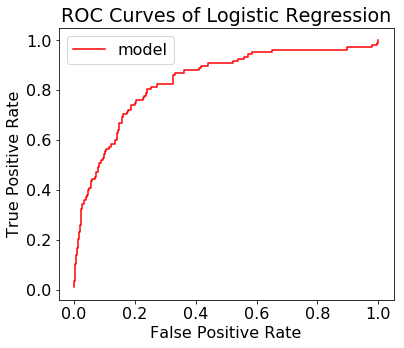

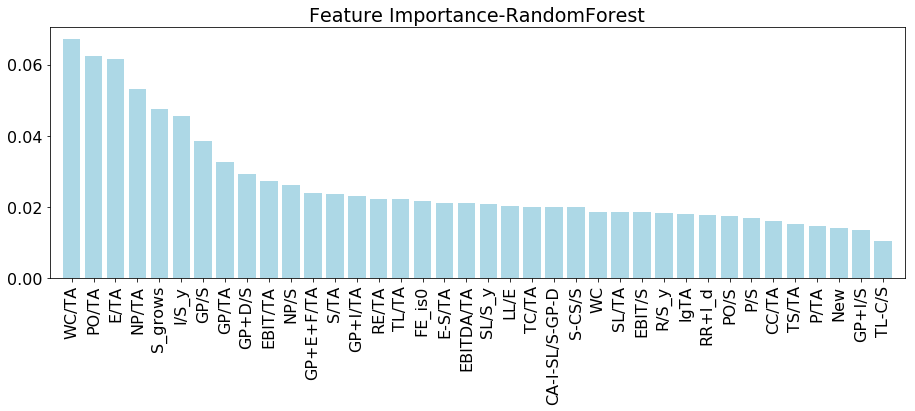

In [7]:
data = df.copy()
# drop '?' samples in lgTA
data.drop(list(data.loc[data.lgTA == '?'].index),inplace=True)

# New = 1 means new companies
data['New'] = 0
data.loc[data['S_grows']=='?','New'] = 1
data['S_grows'] = data['S_grows'].replace('?',1)

# FE_is0 = 1 means FE is 0
data['FE_is0'] = 0
data.loc[data['PO/FE']=='?','FE_is0'] = 1

# drop features, which have '?'
tem = pd.DataFrame((data == '?').sum().sort_values(ascending=False),columns=['not a ?'])
data = data.loc[:,list(tem.loc[tem['not a ?'] == 0].index)]
data = data.replace('?',np.nan)
data = pd.DataFrame(data,dtype=np.float)

Run_Pick(data, 1, 1, importance = 1, matrix = 0, threshold=0 , AUC = 1)

In [8]:
data = data.replace('?',np.nan)
data.dropna()
data = pd.DataFrame(data,dtype=np.float)
pd.set_option('display.max_columns', None)
data.describe()

,WC/TA,PO/TA,E/TA,NP/TA,S_grows,I/S_y,GP/S,GP/TA,GP+D/S,EBIT/TA,NP/S,GP+E+F/TA,S/TA,GP+I/TA,RE/TA,TL/TA,FE_is0,E-S/TA,EBITDA/TA,Bankrupt,SL/S_y,LL/E,TC/TA,CA-I-SL/S-GP-D,S-CS/S,WC,SL/TA,EBIT/S,R/S_y,lgTA,RR+I_d,PO/S,P/S,CC/TA,TS/TA,P/TA,New,GP+I/S,TL-C/S,Id
count,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3.104000e+03,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000
mean,0.155260,-0.080764,0.485187,-0.129964,1.089362,57.055771,-0.186247,-0.117546,-0.135439,-0.117546,-0.192684,-0.098294,1.607740,-0.117546,-0.192565,0.587445,0.081186,0.332775,-0.183641,0.131765,353.637031,0.172114,0.978895,-0.451915,0.034987,1.079321e+04,0.462479,-0.112549,115.731334,4.129581,172.787188,-0.061626,-0.008192,0.572861,2.242026,-0.085935,0.032216,-0.147955,1.205154,3115.615979
std,1.582721,7.760878,5.086219,8.354761,3.124446,192.631091,7.353739,8.355412,7.331181,8.355412,7.318448,8.355027,1.493031,8.355412,9.571363,1.685164,0.273164,5.195663,9.754474,0.338290,8564.124550,5.039776,1.081123,23.907027,0.936918,6.351204e+04,1.456876,2.964870,962.381534,0.846147,1037.446830,2.914265,0.962680,5.080282,17.549577,7.758748,0.176603,7.092510,25.835617,1780.335914
min,-72.067000,-431.590000,-71.444000,-463.890000,-135.150000,-29.340000,-310.800000,-463.890000,-310.340000,-463.890000,-310.890000,-463.890000,-3.496000,-463.890000,-463.890000,0.000000,0.000000,-71.444000,-542.560000,0.000000,-236.530000,-184.980000,-0.164390,-1236.300000,-46.788000,-2.955400e+05,-0.186610,-144.800000,-3946.200000,0.667830,-3975.600000,-143.520000,-47.047000,-71.444000,0.000191,-431.590000,0.000000,-310.800000,-16.110000,0.000000
25%,0.028555,0.000000,0.298940,0.001105,0.982927,18.254750,0.001937,0.002731,0.019637,0.002731,0.000794,0.009534,1.012000,0.002731,0.000000,0.259027,0.000000,0.153323,-0.037050,0.000000,46.182000,0.000000,0.878777,0.013140,0.007557,2.959850e+01,0.183555,-0.029572,38.256750,3.633950,76.352000,0.000000,0.002758,0.414100,1.066075,0.003948,0.000000,0.003966,0.092340,1550.500000
50%,0.205430,0.056650,0.514055,0.043487,1.099700,38.677500,0.032557,0.051340,0.064130,0.051340,0.027905,0.066861,1.140850,0.051340,0.000000,0.466435,0.000000,0.402530,0.014476,0.000000,76.258500,0.004574,0.952840,0.108860,0.049886,1.660950e+03,0.341470,0.009371,59.014000,4.163750,108.095000,0.036774,0.036693,0.609325,1.559800,0.055867,0.000000,0.039696,0.236410,3110.500000
75%,0.411985,0.133057,0.713688,0.113715,1.256800,67.839500,0.085559,0.133310,0.130263,0.133310,0.072709,0.146173,1.836175,0.133310,0.087216,0.676602,0.000000,0.627220,0.090575,0.000000,122.635000,0.197292,0.992735,0.241362,0.121802,7.457250e+03,0.527970,0.057063,85.293250,4.662850,150.060000,0.086072,0.086573,0.770035,2.227800,0.134437,0.000000,0.095039,0.420025,4715.750000
max,28.336000,15.541000,266.860000,5.530000,38.977000,9928.500000,77.244000,5.530000,78.190000,5.530000,77.244000,6.388000,37.807000,5.530000,203.150000,72.416000,1.000000,266.860000,15.541000,1.000000,451380.000000,83.095000,47.788000,87.981000,1.651000,1.634200e+06,72.416000,16.866000,40515.000000,7.661500,40515.000000,18.088000,2.901100,266.860000,965.660000,15.541000,1.000000,77.244000,1236.700000,5909.000000


### Comment:
1. From the above form, we can see the max and min value is very large or very small, and it often happen when financial indicator devided by sales, liability and inventory. The reason is that the sales can be very small, like 1, and then this feature devided 1 will be very large. So these features are actually not so good.
2. Many companies don't have loan, so there are many missing in these part. My idea is just deleteing this feature, whcih divided by short or long term liability, because we can just use 'Liability/ Total Asset' to precent the leverage, and we dont need every indicator devided by liability.
3. We can calculate some indicator by others and use that to replace the features which have many missing.
> for example, 'Sale/Fixed Asset' have many missing because some FA is 0. But we know 'S/TA' and lgTA. So use lgTA to get Total Asset and than get Sale, next we can calculate FA. Finally, use FA/TA to represent this information and delete 'S/FA' feature. I use that we to get many new features.  
Using that way I generate 'Inventory/TA', 'Retained Earnings / Sales', 'Fixed Asset/TA' to replace the previous one, and they do not have any missing.

train data has 2172 sample, test data has 932 sample
Naive Byes: CV score = 0.73, in sample Accuracy = 86.14%, out of sample Accuracy = 88.84%
Logistic: CV score = 0.87, in sample Accuracy = 87.15%, out of sample Accuracy = 88.95%, roc = 80.93%


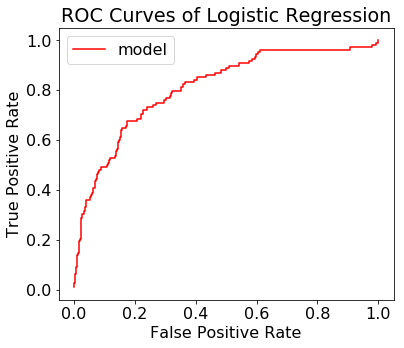

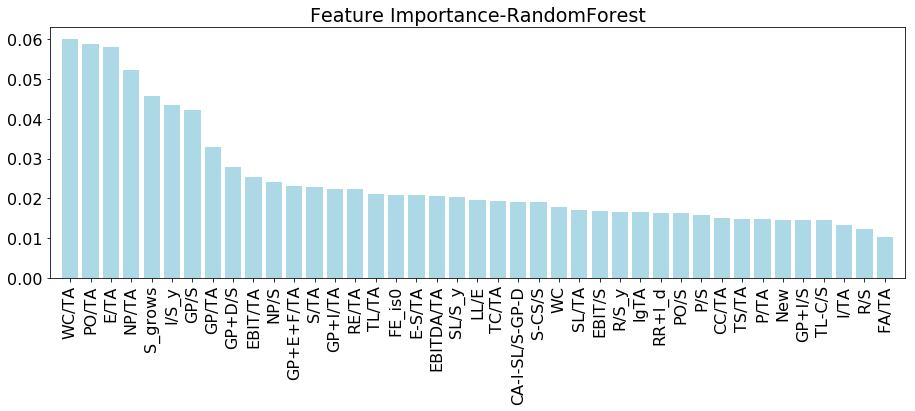

In [9]:
data = df.copy()
data.drop(list(data.loc[data.lgTA == '?'].index),inplace=True)
# New and FE_is0 are just as above
data['New'] = 0
data.loc[data['S_grows']=='?','New'] = 1
data['S_grows'] = data['S_grows'].replace('?',1)
data['FE_is0'] = 0
data.loc[data['PO/FE']=='?','FE_is0'] = 1

tem = pd.DataFrame((data == '?').sum().sort_values(ascending=False),columns=['not a ?'])
data = data.loc[:,list(tem.loc[tem['not a ?'] == 0].index)+['S/FA','S/R']]

data = data.replace('?',np.nan)
data = pd.DataFrame(data,dtype=np.float)
# get Total Asset, get Sales and Gross Profit
data['TA'] = np.power(10, data['lgTA'])
data['S'] = data['S/TA'] * data['TA']
data['GP'] = data['GP/S'] * data['S']
# then we can get Inventory
data['I/TA'] = (data['GP+I/S'] * data['S'] - data['GP']) / data['TA']
# retained earnings / Sales
data['R/S'] = (1 / data['S/R']).fillna(0)
# Fixed Asset
data['FA/TA'] = (data['S'] / data['S/FA']).fillna(0) / data['TA']

del data['S/FA'], data['S/R'],data['S'],data['TA'], data['GP']

Run_Pick(data, 1 ,1, importance = 1, matrix = 0, threshold=0, AUC = 1)

### Comment
1. The feature engineering works, more features add in with out sacrificing the samples.
2. Problems is that many feature is not so important.

### Choosing Features
1. Based on the previous photo of importance of features. I will delete some features which is not important like 'FA/TA', and delete some features have similar meaning with others, like 'GP+I/S', 'WC', 'PO/S'.

train data has 2172 sample, test data has 932 sample
Naive Byes: CV score = 0.88, in sample Accuracy = 87.48%, out of sample Accuracy = 89.59%
Logistic: CV score = 0.90, in sample Accuracy = 90.84%, out of sample Accuracy = 91.09%, roc = 83.70%


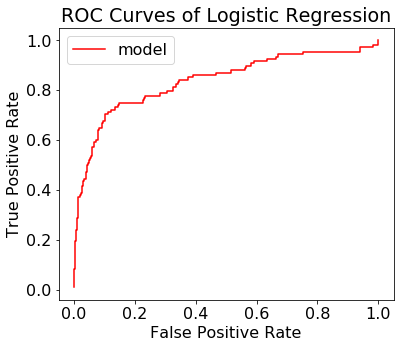

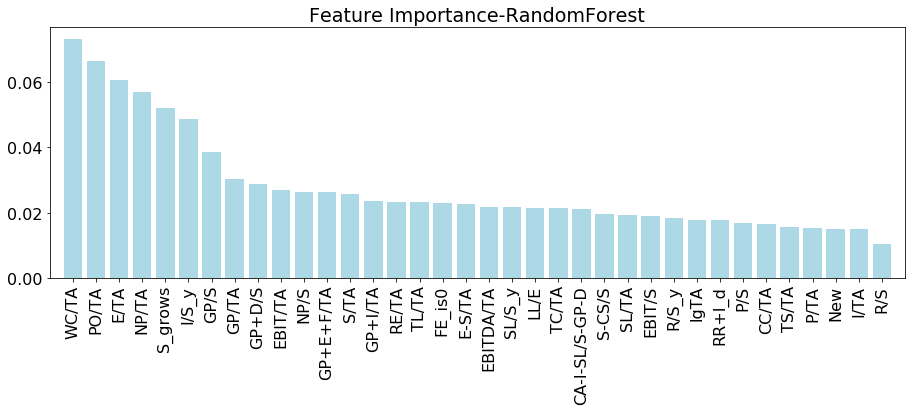

In [10]:
del data['GP+I/S'],data['WC'],data['TL-C/S'], data['FA/TA'], data['PO/S']

Run_Pick(data, 1 ,1, importance = 1, matrix = 0, threshold=0, AUC = 1)

train data has 2172 sample, test data has 932 sample
Naive Byes: CV score = 0.88, in sample Accuracy = 87.48%, out of sample Accuracy = 89.59%
Logistic: CV score = 0.89, in sample Accuracy = 88.95%, out of sample Accuracy = 89.27%, roc = 86.79%

confusion_matrix
 [[770  54]
 [ 46  62]]


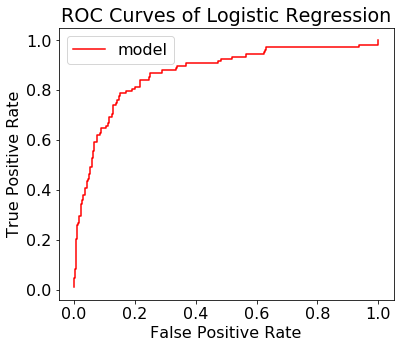

In [11]:
Run_Pick(data, 0.2 ,0.8, importance = 0, matrix = 1, threshold=0, AUC = 1)

### Comment
1. Giving different weight works. The ROC improves.
2. I find that in Sklearn's confusion matrix, the first row i 0. **So what we want to decrease is that actually is 1 but we predict it as 0, literally the left down part.**
3. To do so, I try to use different threshold (lower than 0.5) of Logistic Regression to predict.
<img src="https://tva1.sinaimg.cn/large/006y8mN6gy1g8o8l4upvvj31380cogmg.jpg" width="60%" height="60%" />

In [13]:
# threshold=0.45
Run_Pick(data, 0.2, 0.8, importance = 0, matrix = 1, threshold=0.45 , AUC = 0)

train data has 2172 sample, test data has 932 sample
Naive Byes: CV score = 0.88, in sample Accuracy = 87.48%, out of sample Accuracy = 89.59%
Logistic: CV score = 0.89, in sample Accuracy = 88.67%, out of sample Accuracy = 87.88%, roc = 86.79%

confusion_matrix
 [[750  74]
 [ 39  69]]


In [14]:
# threshold=0.4
Run_Pick(data, 0.2, 0.8, importance = 0, matrix = 1, threshold=0.4 , AUC = 0)

train data has 2172 sample, test data has 932 sample
Naive Byes: CV score = 0.88, in sample Accuracy = 87.52%, out of sample Accuracy = 89.59%
Logistic: CV score = 0.89, in sample Accuracy = 87.43%, out of sample Accuracy = 86.05%, roc = 86.79%

confusion_matrix
 [[727  97]
 [ 33  75]]


In [15]:
# threshold=0.35
Run_Pick(data, 0.2, 0.8, importance = 0, matrix = 1, threshold=0.35 , AUC = 0)

train data has 2172 sample, test data has 932 sample
Naive Byes: CV score = 0.88, in sample Accuracy = 87.52%, out of sample Accuracy = 89.59%
Logistic: CV score = 0.89, in sample Accuracy = 84.94%, out of sample Accuracy = 83.26%, roc = 86.79%

confusion_matrix
 [[691 133]
 [ 23  85]]


In [16]:
# threshold=0.3
Run_Pick(data, 0.2, 0.8, importance = 0, matrix = 1, threshold=0.30 , AUC = 0)

train data has 2172 sample, test data has 932 sample
Naive Byes: CV score = 0.88, in sample Accuracy = 87.52%, out of sample Accuracy = 89.59%
Logistic: CV score = 0.89, in sample Accuracy = 78.27%, out of sample Accuracy = 74.57%, roc = 86.79%

confusion_matrix
 [[601 223]
 [ 14  94]]


### Comment
- I choose the threshold 0.35. Because the accuracy is not so bad and there are only few Negative False. I think to prevent large loss, it is worthwile to sacrifice accuracy. And when threshold decrese, the result does not improve

## Preidcition
- this function need input the train data, test data, threshold and weight, and can output the prediction.

In [17]:
def Prediction(data, test, w0, w1, threshold):
    result = pd.DataFrame(test['Id'])
    result['Bankrupt'] = 0
    result.loc[result.Id == list(test.loc[test.lgTA == '?'].Id)[0], 'Bankrupt'] = 1

    del test ['Id']
    test.drop(list(test.loc[test.lgTA == '?'].index),inplace=True)
    # New and FE_is0 are just as above
    test['New'] = 0
    test.loc[test['S_grows']=='?','New'] = 1
    test['S_grows'] = test['S_grows'].replace('?',1)
    test['FE_is0'] = 0
    test.loc[test['PO/FE']=='?','FE_is0'] = 1

    tem = pd.DataFrame((test == '?').sum().sort_values(ascending=False),columns=['not a ?'])
    test = test.loc[:,list(tem.loc[tem['not a ?'] == 0].index)+['S/FA','S/R']]

    test = test.replace('?',np.nan)
    test = pd.DataFrame(test,dtype=np.float)
    # get Total Asset, get Sales and Gross Profit
    test['TA'] = np.power(10, test['lgTA'])
    test['S'] = test['S/TA'] * test['TA']
    test['GP'] = test['GP/S'] * test['S']
    # then we can get Inventory
    test['I/TA'] = (test['GP+I/S'] * test['S'] - test['GP']) / test['TA']
    # retained earnings / Sales
    test['R/S'] = (1 / test['S/R']).fillna(0)
    # Fixed Asset
    test['FA/TA'] = (test['S'] / test['S/FA']).fillna(0) / test['TA']

    del test['S/FA'], test['S/R'],test['S'],test['TA'], test['GP']
    del test['GP+I/S'],test['WC'],test['TL-C/S'], test['FA/TA'], test['PO/S']

    x, y = data.iloc[:,:].copy(), data['Bankrupt']
    del x['Bankrupt'], x['Id']
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=10)
    print("train data has {a} sample, test data has {b} sample".format(a = len(x_train), b = len(test)))

    model = LogisticRegression(penalty='l2',C=1,class_weight={1:w1,0:w0}) 
    model.fit(x_train, y_train) 
    y_pred_prob = model.predict_proba(test)[:,1]
    y_pred = y_pred_prob > threshold
    y_pred = y_pred + 0

    result.loc[result.Bankrupt == 0, 'Bankrupt'] = y_pred
    
    return result

In [ ]:
Attribute Information:

Id Company Identifier 
X1 net profit / total assets
X2 total liabilities / total assets
X3 working capital / total assets
X4 current assets / short-term liabilities
X5 [(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365
X6 retained earnings / total assets
X7 EBIT / total assets
X8 book value of equity / total liabilities
X9 sales / total assets
X10 equity / total assets
X11 (gross profit + extraordinary items + financial expenses) / total assets
X12 gross profit / short-term liabilities
X13 (gross profit + depreciation) / sales
X14 (gross profit + interest) / total assets
X15 (total liabilities * 365) / (gross profit + depreciation)
X16 (gross profit + depreciation) / total liabilities
X17 total assets / total liabilities
X18 gross profit / total assets
X19 gross profit / sales
X20 (inventory * 365) / sales
X21 sales (n) / sales (n-1)
X22 profit on operating activities / total assets
X23 net profit / sales
X24 gross profit (in 3 years) / total assets
X25 (equity - share capital) / total assets
X26 (net profit + depreciation) / total liabilities
X27 profit on operating activities / financial expenses
X28 working capital / fixed assets
X29 logarithm of total assets
X30 (total liabilities - cash) / sales
X31 (gross profit + interest) / sales
X32 (current liabilities * 365) / cost of products sold
X33 operating expenses / short-term liabilities
X34 operating expenses / total liabilities
X35 profit on sales / total assets
X36 total sales / total assets
X37 (current assets - inventories) / long-term liabilities
X38 constant capital / total assets
X39 profit on sales / sales
X40 (current assets - inventory - receivables) / short-term liabilities
X41 total liabilities / ((profit on operating activities + depreciation) * (12/365))
X42 profit on operating activities / sales
X43 rotation receivables + inventory turnover in days
X44 (receivables * 365) / sales
X45 net profit / inventory
X46 (current assets - inventory) / short-term liabilities
X47 (inventory * 365) / cost of products sold
X48 EBITDA (profit on operating activities - depreciation) / total assets
X49 EBITDA (profit on operating activities - depreciation) / sales
X50 current assets / total liabilities
X51 short-term liabilities / total assets
X52 (short-term liabilities * 365) / cost of products sold)
X53 equity / fixed assets
X54 constant capital / fixed assets
X55 working capital
X56 (sales - cost of products sold) / sales
X57 (current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation)
X58 total costs /total sales
X59 long-term liabilities / equity
X60 sales / inventory
X61 sales / receivables
X62 (short-term liabilities *365) / sales
X63 sales / short-term liabilities
X64 sales / fixed assets